In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    print("Success: Running on Apple Silicon GPU")
else:
    print("MPS not available")

Success: Running on Apple Silicon GPU


In [1]:
%pip install matplotlib



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline





In [3]:
def f(x):
  return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

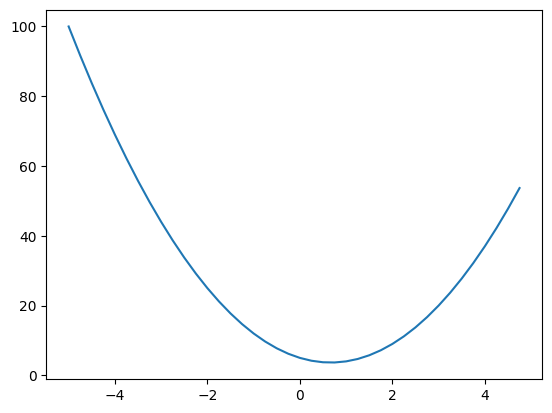

In [5]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
ys
plt.plot(xs,ys)

In [6]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/ h

2.999378523327323e-06

In [7]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.0001


a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print(d1)
print(d2)

print((d2-d1)/h)


4.0
4.0001
0.9999999999976694


In [9]:
%pip install graphviz
%pip install micrograd


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:

from graphviz import Digraph

from micrograd.engine import Value

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})
    
    for n in nodes:
        # 1. FIXED: Added a placeholder 0.0 for grad since you haven't calculated it yet
        uid = str(id(n))
        dot.node(name=uid, label = "{ %s | data %.4f| grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            # 2. FIXED: 'uid' was undefined in your code; defined it above
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


In [11]:
# playing with the class Value --- 


class Value:
  def __init__ (self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label  
    
    
  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, _children=(self, other), _op='+')
    def _backward():
        self.grad  = 1.0 * out.grad
        other.grad = 1 * out.grad
    out._backward = _backward
        
    return out

  def __neg__(self): # -self
      return self * -1
  def __sub__(self, other): # self + -other
      return self + (-other)
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, _children=(self, other), _op='*')
    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __pow__(self, other):
      
      assert isinstance(other, (int, float))
      out = Value(self.data ** other, (self, ), f'**{other}')

      

      def _backward():
          self.grad += other * (self.data ** (other - 1)) * out.grad
      out._backward = _backward

      return out

  def __rmul__(self, other): # passign in other * self, and then swapping the values in the return 
      
      return self * other

  def __radd__(self, other): # other + self 
      return self + other

  def __truediv__(self, other): # self / other
      return self * other**-1

  def ReLU(self):
      x = self.data if self.data > 0 else 0
      out = Value(x, (self, ), 'ReLU')


      def _backward():
          if x > 0:
              self.grad += out.grad

          else:
              self.grad += 0
      out._backward = _backward

      return out
        

  def tanh(self):
      x = self.data
      t = (math.exp(2*x) - 1)/(math.exp(2*x)+ 1)
      out = Value(t, (self, ), 'tanh')

      def _backward():
          self.grad += (1- t ** 2) * out.grad

      out._backward = _backward
      
      return out


  def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad # not += not =
        out._backward = _backward
        return out
        


  def backward(self): 
    topo = []
    
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
        node._backward()
      
       
    


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0,label='c')
e = a*b 
e.label='e'
d = c + e 
d.label='d'
f = Value(-2.0, label='f')

L = d * f 
L.label = 'L'


L

Value(data=-8.0)

In [12]:
def test_sanity_check():
    a = Value(3.0)
    b = a + a
    print(b)
    b.backward()
    print(f"Should be 2.0, got: {a.grad}") 
    # If you get 1.0, you have the bug.

test_sanity_check()

Value(data=6.0)
Should be 2.0, got: 1.0


In [13]:
# implementing rmul to take care of #2



# 1. a * 1
a = Value(4.0)
b = Value(3.0)

# a / b



a - b

# 1.__mul__(a)

Value(data=1.0)

In [14]:
# implementing the division
# 

In [15]:
L.grad = 1.0
a.grad = 6.0
b.grad = -4.0
e.grad = -2.0
c.grad = -2.0
d.grad = -2.0
f.grad = 4.0

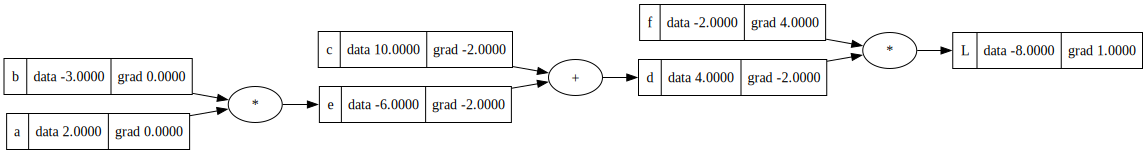

In [16]:
draw_dot(L)

In [17]:
# rechecking the above results by calculating the derivatives manually

def lol():
    h = 0.001
       
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0,label='c')
    e = a*b 
    e.label='e'
    d = c + e 
    d.label='d'
    f = Value(-2.0, label='f')
    
    L = d * f 
    L.label = 'L'
    L1 = L.data




           
    a = Value(2.0, label='a')
    
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0,label='c')
    e = a*b 
    e.label='e'
    d = c + e 
    d.label='d'
    f = Value(-2.0, label='f')
    
    L = d * f 
    L.label = 'L'
    L2 = L.data


    print((L2-L1)/h)


lol()

-3.9999999999995595


In [18]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad


e = a * b
d = e + c
L = d * f

print(L.data)

-43.115295999999994


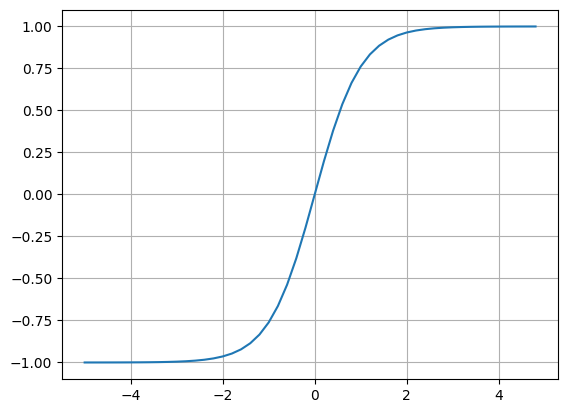

In [19]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [20]:
# inputs x1, x2

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1, w2

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

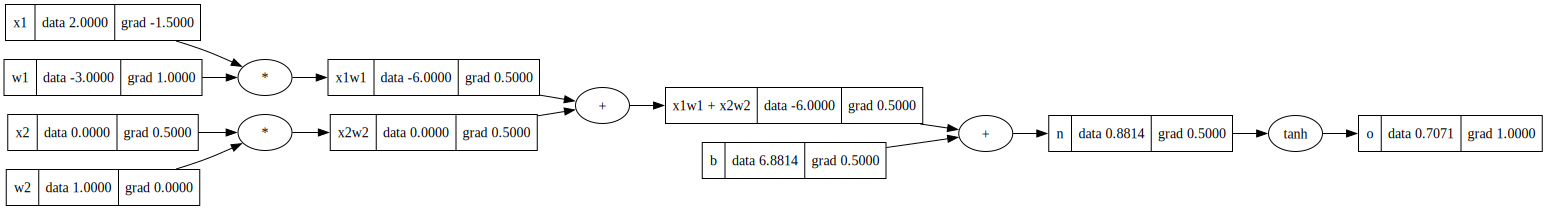

In [21]:
draw_dot(o)

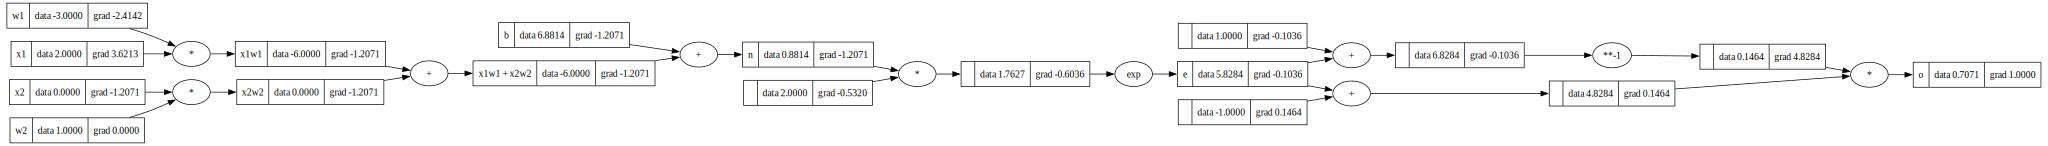

In [22]:

# inputs x1, x2

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1, w2

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'



e = (2*n).exp(); e.label = 'e'

o = (e - 1)/ (e + 1); o.label = 'o'



o.backward()

draw_dot(o)

In [23]:
#toplogical sort

o.grad = 1.0

topo = []

visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)


for node in reversed(topo):
    node._backward()

build_topo(o)
topo

        

[Value(data=1),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=2),
 Value(data=1.7627471740390863),
 Value(data=5.828427124746192),
 Value(data=6.828427124746192),
 Value(data=0.1464466094067262),
 Value(data=-1),
 Value(data=4.828427124746192),
 Value(data=0.7071067811865477)]

In [24]:
1- o.data**2

0.4999999999999998

In [25]:
 # o = tanh(n)
# do/dn =?
# = 1- o**2
b


Value(data=6.881373587019543)

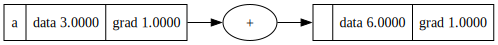

In [26]:
a = Value(3.0, label ='a')
b = a + a
b.backward()
draw_dot(b)


In [27]:
# implementing the above neuron in pytorch

import torch


In [28]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True

b = torch.Tensor([6.881373587019543]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [29]:
o.item()

0.7071066904050358

In [30]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [31]:
# building a neural network library ( multi layer Perceptron) in micrograd
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

      


    

In [54]:

x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)
    
    

Value(data=-0.5484832183917301)

In [55]:
n(x)

Value(data=-0.5484832183917301)

In [34]:
len(n.parameters())

41

In [33]:
xs = [
    [-2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [46]:
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred
loss = sum((yout - ygt)** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=1.533050845393289)

In [47]:
loss.backward()

In [38]:
n.layers[0].neurons[0].w[0].grad

0.12314422254521733

In [39]:
n.layers[0].neurons[0].w[0].data

0.5173971326801694

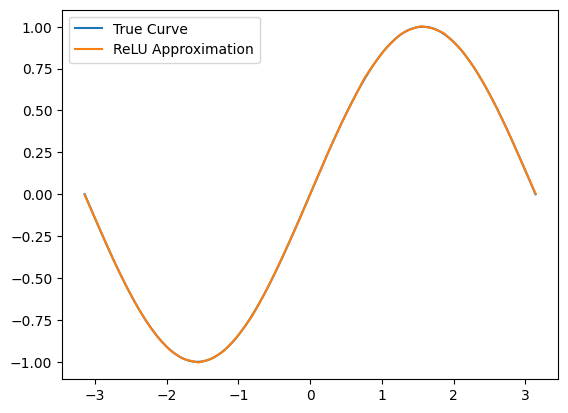

In [40]:
import torch
import matplotlib.pyplot as plt

# 1. Create a "Curved" Dataset (Sine wave)
x = torch.linspace(-np.pi, np.pi, 200).unsqueeze(1)
y = torch.sin(x)

# 2. Define a model with ReLU (The "Folder")
# Try changing hidden_neurons to 2, then 5, then 50.
hidden_neurons = 100
model = torch.nn.Sequential(
    torch.nn.Linear(1, hidden_neurons),
    torch.nn.ReLU(),               # <--- The Magic Crease
    torch.nn.Linear(hidden_neurons, 1)
)

# 3. Train (Standard Loop)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for i in range(1000):
    loss = torch.nn.MSELoss()(model(x), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 4. Plot
plt.plot(x.numpy(), y.numpy(), label="True Curve")
plt.plot(x.numpy(), model(x).detach().numpy(), label="ReLU Approximation")
plt.legend()
plt.show()

In [62]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [63]:
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred
loss = sum((yout - ygt)** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.000719392209625233)

In [64]:
loss.backward()

In [65]:
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9738132468663449),
 Value(data=-0.9999703036135417),
 Value(data=-0.9999795993120655),
 Value(data=0.9941995800256535)]

In [43]:
n.layers[0].neurons[0].w[0].data

0.39425291013495206

In [44]:
n.layers[0].neurons[0].w[0].grad

0.12314422254521733

In [38]:
for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)** 2 for ygt, yout in zip(ys, ypred))

    #backward pass
    loss.backward()


    #nudging the value - gradient discent
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)
    

0 0.4463428843822958
1 0.055458989939541715
2 0.002668807845314979
3 8.031495433664853e-05
4 2.9366948095365593e-06
5 1.7433814303068498e-07
6 1.5606276372642612e-08
7 1.9355946080670836e-09
8 2.211935941819624e-11
9 2.3587025119789907e-19
10 4.765864935068989e-21
11 1.314471628543582e-22
12 4.025721935686546e-24
13 1.2773445318516572e-25
14 4.1020890331009055e-27
15 1.3056880576572153e-28
16 4.289431172139252e-30
17 9.860761315262648e-32
18 0.0
19 0.0


In [39]:
ypred

[Value(data=1.0), Value(data=-1.0), Value(data=-1.0), Value(data=1.0)]

In [44]:
import time

In [56]:
# Comparison loop between python and C++ implementation

model = MLP(3, [4,4,1])


x = [Value(2.0), Value(3.0), Value(-1.0)]

print("Starting Python Benchmark (100,000 iterations)...")

start_time = time.time()

for i in range(100000):
    out = model(x)

    out.backward()

end_time = time.time()
elapsed = end_time - start_time

print("Done")
print(f"Time taken: {elapsed:.4f} seconds")
print(f"Ops/sec: {100000.0 / elapsed:.2f}")

Starting Python Benchmark (100,000 iterations)...
Done
Time taken: 17.2803 seconds
Ops/sec: 5786.94
